$Name$ : $Team$ $35$ <br>
$Topic$ : $Solar$ $Power$ $Time$ $Series$ $Forecasting$ $(EDA)$

In the following notebook, we have executed Exploratory Data Analysis on our raw datasets of Solar Energy and Weather Information<br><br>
We will first all the relevant libraries.

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

"time_series.csv"corresponds to the dataset that contains Time Series data about solar power generated.<br>
"weather_data_f.csv" corresponds to hourly data about weather status like precipitation, radiation, cloud_cover, etc.

Data Source (Solar) : https://data.open-power-system-data.org/time_series/<br>
Data Source (Wind) : https://data.open-power-system-data.org/weather_data/

In [ ]:
data = pd.read_csv("time_series.csv")
weather = pd.read_csv("weather_data_f.csv")

## Data Wrangling

First, we will have a look at all the columns in our solar energy dataset.

In [ ]:
data.columns

Index(['utc_timestamp', 'cet_cest_timestamp',
       'DE_load_actual_entsoe_power_statistics',
       'DE_load_actual_entsoe_transparency',
       'DE_load_forecast_entsoe_transparency', 'DE_price_day_ahead',
       'DE_solar_capacity', 'DE_solar_generation_actual', 'DE_solar_profile',
       'DE_wind_capacity', 'DE_wind_generation_actual', 'DE_wind_profile',
       'DE_wind_offshore_capacity', 'DE_wind_offshore_generation_actual',
       'DE_wind_offshore_profile', 'DE_wind_onshore_capacity',
       'DE_wind_onshore_generation_actual', 'DE_wind_onshore_profile'],
      dtype='object')

Next, we will subset the data, including the columns and rows that we need.

In [ ]:
data = data[['utc_timestamp', 'cet_cest_timestamp', 'DE_price_day_ahead',
       'DE_solar_capacity', 'DE_solar_generation_actual', 'DE_solar_profile',
       'DE_wind_capacity']]

Since there is no record of solar power generation before 2012, we have majorly NA values across all attributes. Since EDA around solar energy generation/consumption is the main goal, we have deleted these records with missing information about solar power generation, which amount to about 61,403 rows.


In [ ]:
data['DE_solar_generation_actual'].isnull().sum()

61403

In [ ]:
data = data[~data['DE_solar_generation_actual'].isnull()]

The final shape of our remaining data is 64,190 rows and 7 columns.

In [ ]:
data.shape

(64190, 7)

In [ ]:
data.describe()

,DE_price_day_ahead,DE_solar_capacity,DE_solar_generation_actual,DE_solar_profile,DE_wind_capacity
count,63537.000000,61819.000000,64190.000000,61819.000000,61819.000000
mean,36.295120,37727.686472,3861.153170,0.102108,41281.688478
std,16.692367,4505.836606,6007.199875,0.157421,10465.615183
min,-221.990000,26053.000000,0.000000,0.000000,26663.000000
25%,27.080000,35462.000000,0.000000,0.000000,31058.000000
50%,35.010000,38352.000000,116.000000,0.003200,40704.000000
75%,45.460000,40982.000000,6058.000000,0.161400,50438.000000
max,210.000000,44958.000000,30028.000000,0.790800,58901.000000


**DE_price_day_ahead** : Day-ahead spot price for Germany in EUR<br>
**DE_solar_capacity** : Electrical capacity of solar in Germany in MW<br>
**DE_solar_generation_actual** : Actual solar generation in Germany in MW<br>
**DE_solar_profile** : Share of solar capacity producing in Germany<br>
**DE_wind_capacity** : Electrical capacity of wind in Germany in MW<br>

Now, we will first convert the date column in our dataset into day time for easier interpretation<br>

In [ ]:
data['day_time'] = pd.to_datetime(data['utc_timestamp']).dt.tz_convert('Europe/Berlin')

In the following code snippet, we have calculated the total number of days in our days to verify the total rows in the dataset. We can see that two of the rows do not have date values.

In [ ]:
delta_time = max(data['day_time'])-min(data['day_time'])
print("Expected number of rows:", int(delta_time.days*24 +delta_time.seconds/3600 +1))
print("Total number of rows", data.shape[0] )

Expected number of rows: 64236
Total number of rows 64190


Since 2 rows out of 64,190 is a very minimal number, we can ignore it.

In [ ]:
weather.columns

Index(['utc_timestamp', 'DE_temperature', 'DE_radiation_direct_horizontal',
       'DE_radiation_diffuse_horizontal', 'DE_precipitation', 'DE_cloud_cover',
       'DE_snow_mass', 'DE_air_density', 'DE_snowfall'],
      dtype='object')

In [ ]:
weather['day_time'] = pd.to_datetime(weather['utc_timestamp']).dt.tz_convert('Europe/Berlin')

Using the minimum and maximum date in our solar generation dataset, we will subset our weather dataset accordingly using the following code. <br>
This gives us a total of 64,236 rows and 10 columns in our weather dataset.

In [ ]:
weather = weather[weather['day_time']>=data.day_time.min()]
weather = weather[weather['day_time']<=data.day_time.max()]

In [ ]:
weather.shape

(64236, 10)

In order to make both the datasets consistent, solar and weather, we will remove the two rows that have empty values for date in the solar dataset.

In [ ]:
tm_data = list(data.day_time)
tm_weather = list(weather.day_time)
j = 0
tm_missing = []
for i in range(0,len(tm_data)):
    if (tm_data[i]!=tm_weather[j]):
        while tm_data[i]!=tm_weather[j]:
            tm_missing.append(tm_weather[j])
            j+=1
    j+=1

In [ ]:
weather = weather[~weather.day_time.isin(tm_missing)]
weather.shape

(64190, 10)

We see that we do not have any missing values in the weather dataset.

In [ ]:
weather.describe()

,DE_temperature,DE_radiation_direct_horizontal,DE_radiation_diffuse_horizontal,DE_precipitation,DE_cloud_cover,DE_snow_mass,DE_air_density,DE_snowfall
count,64190.000000,64190.000000,64190.000000,64190.000000,64190.00000,64190.000000,64190.000000,64190.000000
mean,9.297105,79.520956,67.443912,0.086084,0.60033,0.966918,1.213287,0.007204
std,8.059124,154.466904,89.994604,0.136701,0.24770,2.461012,0.036261,0.027122
min,-16.381000,0.000000,0.000000,0.000000,0.00000,0.000000,1.116800,0.000000
25%,2.913250,0.000000,0.000000,0.005400,0.42160,0.000000,1.185500,0.000000
50%,8.779000,0.377750,5.765750,0.030950,0.62715,0.001600,1.211900,0.000000
75%,15.390000,74.828350,120.894675,0.109200,0.80400,0.387775,1.239900,0.001300
max,34.298000,841.681000,393.525600,2.311800,0.99740,21.855800,1.359500,0.831100


**DE_temperature** : temperature weather variable for Germany in degrees C<br>
**DE_radiation_direct_horizontal** : radiation_direct_horizontal weather variable for Germany in W/$m^2$<br>
**DE_radiation_diffuse_horizontal** : radiation_diffuse_horizontal weather variable for Germany in W/$m^2$ <Br>
**DE_precipitation** : precipitation measured for Germany in mm<br>
**DE_cloud_cover** : Measure of cloud cover for Germany in okta<br>
**DE_snow_mass** : Measure of snow mass in Germany in kg/$m^3$<br>
**DE_air_density** : Measure of air density in Germany in kg/$m^3$<br>
**DE_snowfall** : Measure of snowfall in Germany in cm

## Data Exploration

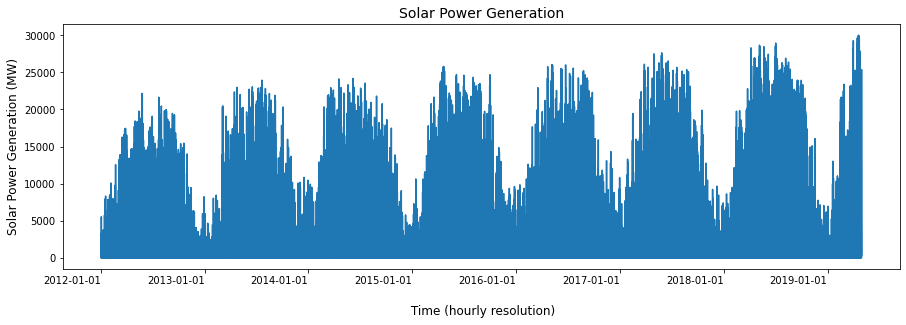

In [ ]:
data.plot("day_time","DE_solar_generation_actual",legend=False,figsize=(15,5))
plt.xlabel("\n Time (hourly resolution)",fontsize=12)
plt.title("Solar Power Generation",fontsize=14)
plt.ylabel("Solar Power Generation (MW)", fontsize=12)
dates = pd.date_range('2012', '2019', freq=pd.DateOffset(years=1))
plt.xticks(dates, rotation =0)
plt.show()

From the above given plot, we can clearly see an **$increase$** in the total Solar Power generated in MW units from 2012 to 2019.

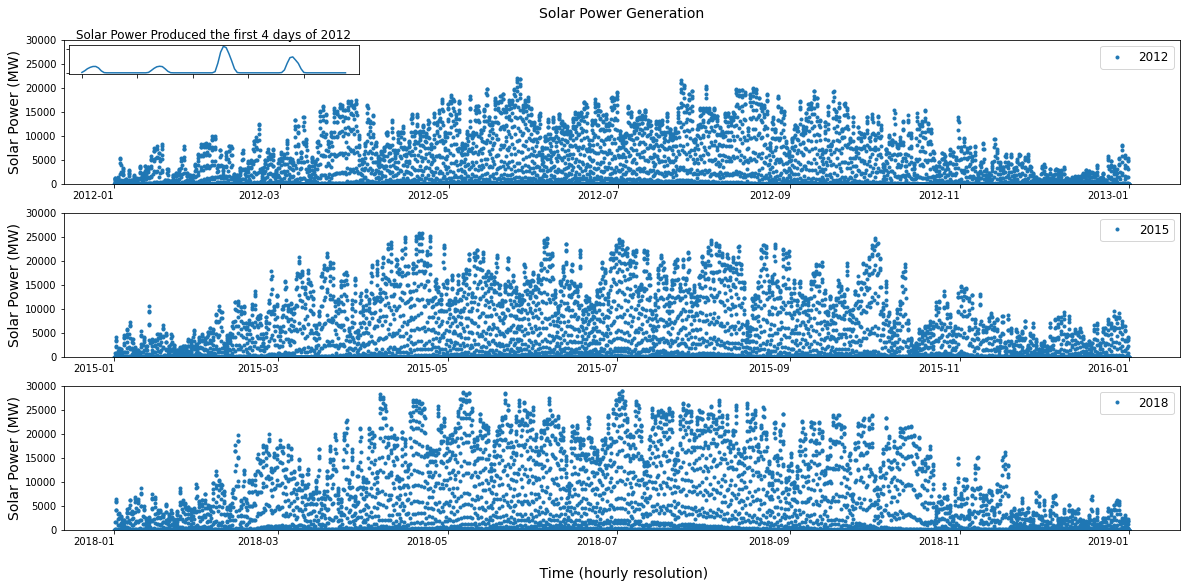

In [ ]:
d_2012 = data[data['day_time'].apply(lambda s:s.year==2012)]
d_2015 = data[data['day_time'].apply(lambda s:s.year==2015)]
d_2018 = data[data['day_time'].apply(lambda s:s.year==2018)]

fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(20,10))
axes[0].set_title("Solar Power Generation\n",fontsize=14)

d_2012.plot("day_time","DE_solar_generation_actual",label="2012", ax=axes[0],style='.')
axes[0].set_xlabel("",fontsize=12)

d_2015.plot("day_time","DE_solar_generation_actual",label="2015", ax=axes[1],style='.')
axes[1].set_xlabel("",fontsize=12)

d_2018.plot("day_time","DE_solar_generation_actual",label="2018", ax=axes[2],style='.')
axes[2].set_xlabel("\n Time (hourly resolution)",fontsize=14)

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

axins = zoomed_inset_axes(axes[0], 1, loc= "upper left")
axins.plot(range(0,24*4), d_2012.DE_solar_generation_actual.iloc[0:24*4])
#mark_inset(axes[0], axins, loc1='lower left' , loc2='upper left', fc='none')
#x1,x2,y1,y2 = d_2012.day_time.iloc[0], d_2012.day_time.iloc[24*4-1],0,5000
axins.set_yticklabels("")
axins.set_xticklabels("")
axins.set_title("Solar Power Produced the first 4 days of 2012")
#axins.set_ylim(0,500)
#axes[0].indicate_inset_zoom(axins)

for ax in axes:
    ax.legend(fontsize=12)
    ax.set_ylim([0,30000])
    ax.set_ylabel("Solar Power (MW)", fontsize=14)
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
plt.show()

**Increased Production Over the Years and Months**

Taken at an hourly resolution and when plotted against the total power generated for 2012, 2015 and 2018, we can see how more and more solar energy has been generated during the summer months for each year as we go from 2012 to 2018. <br><br>
Additionally, we can also observe that as we go from 2012 to 2018, the span of months during which a significant amount of solar energy is recorded, expands by 1 month for every consequent year.

In [ ]:
data['year']= data['day_time'].apply(lambda s:s.year)
data['month']= data.day_time.apply(lambda s:s.month)
data['hour']= data.day_time.apply(lambda s:s.hour)

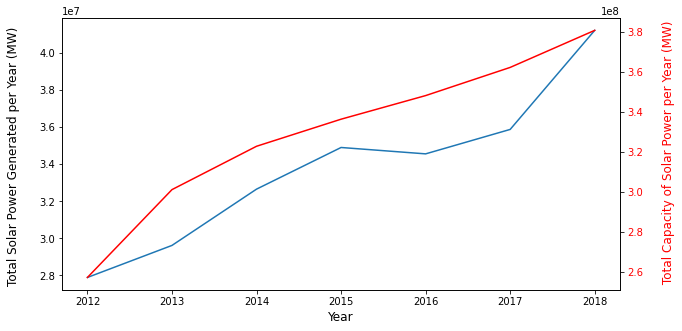

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(data.groupby('year')['DE_solar_generation_actual'].sum()[:-1])
ax1.set_ylabel('Total Solar Power Generated per Year (MW) \n', fontsize=12)

ax2 = ax1.twinx()
ax2.plot(data.groupby('year')['DE_solar_capacity'].sum()[:-1],'r-')
ax2.set_ylabel('\n Total Capacity of Solar Power per Year (MW)',color='r',fontsize=12)

for t in ax2.get_yticklabels():
    t.set_color('r')
ax1.set_xlabel("Year", fontsize=12)
plt.show()

**Usage of Near Full Capacity of Solar Power Generation Possible**

From the above graph, we can observe that as we proceed from 2012 to 2018, there is a clear indication of an $increase$ in the solar energy generated, almost parallel to the increase in capacity of solar power that can be generated in a maximization scenario.

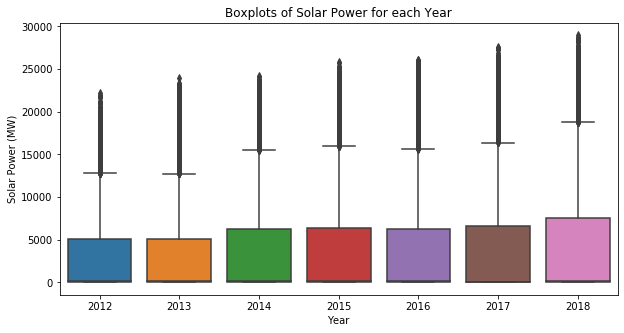

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='year',y='DE_solar_generation_actual',data=data[data.year!=2019])
plt.xlabel('Year')
plt.ylabel('Solar Power (MW)')
plt.title('Boxplots of Solar Power for each Year')
plt.savefig('boxyear.jpg')
plt.show()

In the above graph, we have shown how the total Solar Power generated (MW) has increased from 2012 to 2018.

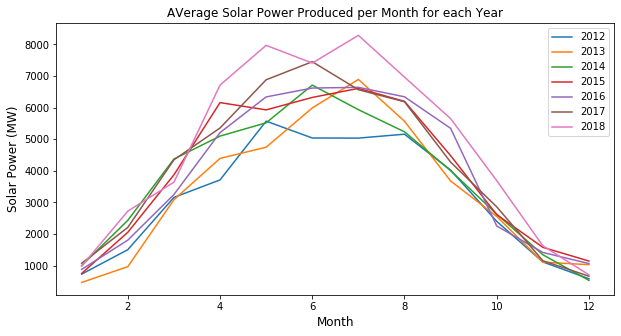

In [ ]:
plt.figure(figsize=(10,5))
for y in [2012, 2013, 2014,2015,2016,2017,2018]:
    plt.plot(data[data.year==y].groupby('month').DE_solar_generation_actual.mean(),label=y)
plt.legend()
plt.title("AVerage Solar Power Produced per Month for each Year")
plt.xlabel("Month",fontsize=12)
plt.ylabel("Solar Power (MW)",fontsize=12)
plt.show()

**More Months Generate Significant Levels of Solar Energy**

In the above graph, we can clearly see that for the year of 2012, while there have been only a few summer months when maximum solar energy was generated, as we reach 2018, the total number of months almost amount to more than half in a year for significant solar energy production.

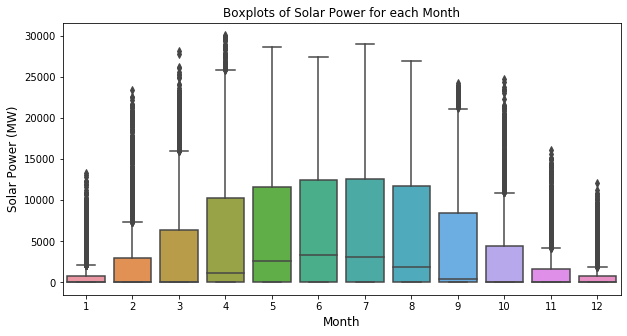

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='month',y='DE_solar_generation_actual',data=data)
plt.xlabel('Month',fontsize=12)
plt.ylabel('Solar Power (MW)',fontsize=12)
plt.title('Boxplots of Solar Power for each Month')
plt.savefig('boxmonth.jpg')
plt.show()

Almost all the months, except for November, December and January produce a significant amount of solar energy (MW).

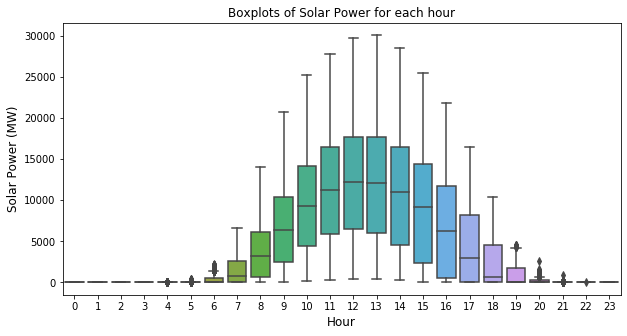

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='hour',y='DE_solar_generation_actual',data=data)
plt.xlabel('Hour',fontsize=12)
plt.ylabel('Solar Power (MW)',fontsize=12)
plt.title('Boxplots of Solar Power for each hour')
plt.savefig('boxhour.jpg')
plt.show()

**Maximum Solar Energy Generated at Noon**<br>
<br>
From the graph above, we can clearly see that solar energy is generated right from morning 7:00 AM until evening 7 :00 PM,with the mean of this normal distribution at 1:00 PM, merely leaving out the hours at night.

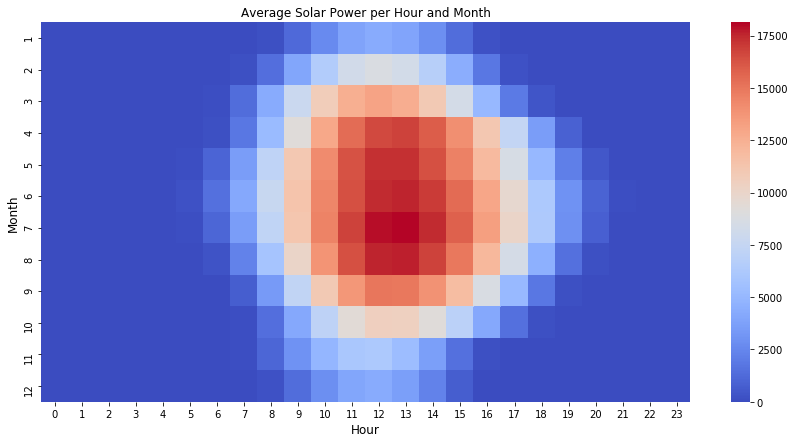

In [ ]:
plt.figure(figsize=(12,6))
d_pivot = pd.pivot_table(data=data,columns="hour",index= "month", values="DE_solar_generation_actual")
sns.heatmap(d_pivot,cmap='coolwarm')
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.tight_layout()
plt.xlabel('Hour', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.title('Average Solar Power per Hour and Month')
plt.savefig('heatmap.png')
plt.show()

The above graph shows us a distribution of solar energy generated when taken month by hour.

<Figure size 1440x720 with 0 Axes>

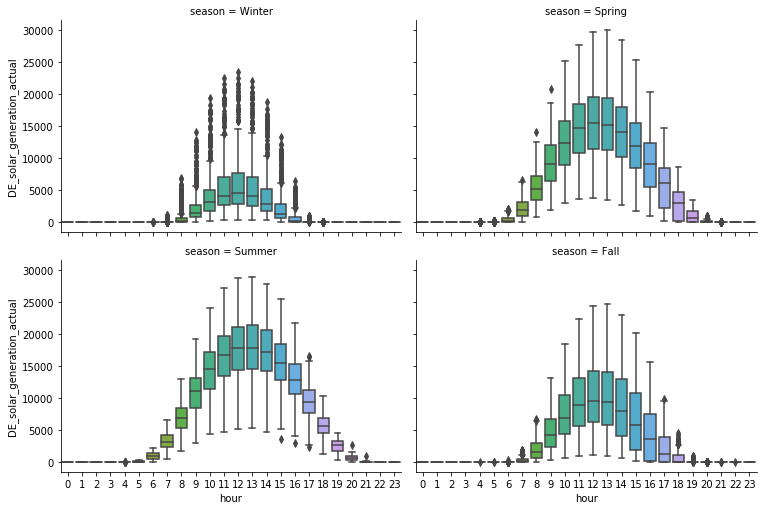

In [ ]:
def season(m):
    if m in [12,1,2]:
        return 'Winter'
    if m in [3,4,5]:
        return 'Spring'
    if m in [6,7,8]:
        return 'Summer'
    if m in [9,10,11]:
        return 'Fall'
data['season'] = data['month'].apply(season)

plt.figure(figsize=(20,10))
g = sns.catplot(x="hour", y='DE_solar_generation_actual',col="season", col_wrap=2,
                data=data,
                kind="box", height=3.5, aspect=1.5)
plt.savefig('boxseasons.png')
plt.show()

**Hourly Distribution of Solar Energy Generation By Seasons**<br>
<Br>
We can clearly see, that seasons Spring and Summer have a very identical distribution for Solar Power generation, However, we can see that least amount of Solar Power is generated in Winter.

**Autocorrelation (Solar Power Generation)**

In [ ]:
import pandas.util.testing as tm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
lag_acf = acf(data.DE_solar_generation_actual, nlags=24, fft=False)

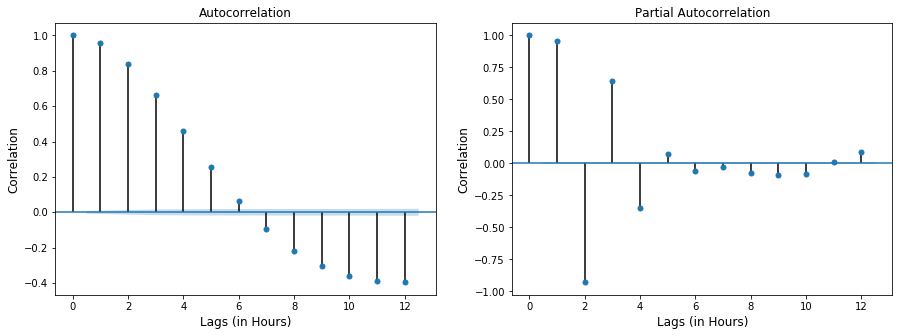

In [ ]:
from pandas.plotting import autocorrelation_plot

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))


plot_acf(data.DE_solar_generation_actual,ax=axes[0],lags=12)
plot_pacf(data.DE_solar_generation_actual,ax=axes[1],lags=12)

for ax in axes:
    ax.set_xlabel("Lags (in Hours)", fontsize=12)
    ax.set_ylabel("Correlation",fontsize=12)

plt.savefig("auto.png")
plt.show()

In order to study this pattern of lagging hours and their correlation, we used an autocorrelation function which we can see in this graph. <br>
On the y-axis, we have the correlation coefficient and on the x axis we have the lagging in terms of number of hours. We can clearly see that the correlation decreases from 1 to -0.4 as we lag the number of hours from 0 to 12. <br> 
This suggests that we can more confidently speak about how much solar energy would be generated in the first hour after say 12 PM compared to how much solar energy would be generated in the tenth hour after 12 PM.

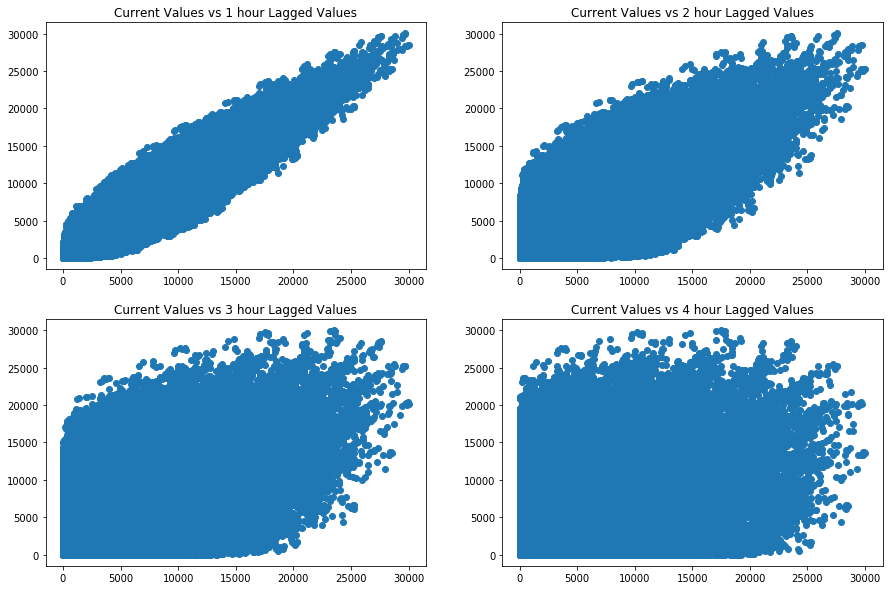

In [ ]:
#plt.scatter(data.DE_solar_generation_actual.iloc[0:-1],data.DE_solar_generation_actual.iloc[1:])
#plt.show()
#.Scatter(x=data.DE_solar_generation_actual.iloc[0:-1],y=data.DE_solar_generation_actual.iloc[1:],mode='markers'),

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(15,10))

axes[0][0].scatter(x=data.DE_solar_generation_actual.iloc[0:-1],
                   y=data.DE_solar_generation_actual.iloc[1:])
axes[0][0].set_title("Current Values vs 1 hour Lagged Values")
axes[0][1].scatter(x=data.DE_solar_generation_actual.iloc[0:-2],y=data.DE_solar_generation_actual.iloc[2:])
axes[0][1].set_title("Current Values vs 2 hour Lagged Values")
axes[1][0].scatter(x=data.DE_solar_generation_actual.iloc[0:-3],y=data.DE_solar_generation_actual.iloc[3:])
axes[1][0].set_title("Current Values vs 3 hour Lagged Values")
axes[1][1].scatter(x=data.DE_solar_generation_actual.iloc[0:-4],y=data.DE_solar_generation_actual.iloc[4:])
axes[1][1].set_title("Current Values vs 4 hour Lagged Values")

plt.show()


One important part of our project is to study how the solar energy generated in a consequently following hour is related to the current hour in consideration. 
<br>
That is what these graphs tell us. We can see in the upper right corner graph that there is stronger correlation between solar power generation at the first hour and the second hour, when compared to other graphs with higher lagging hours.


### Time Series Analysis

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
tsd = data[['day_time','DE_solar_generation_actual']].set_index('day_time')
result = seasonal_decompose(tsd,freq=24*365)

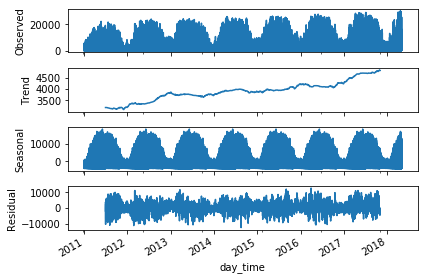

In [ ]:
result.plot()
plt.show()

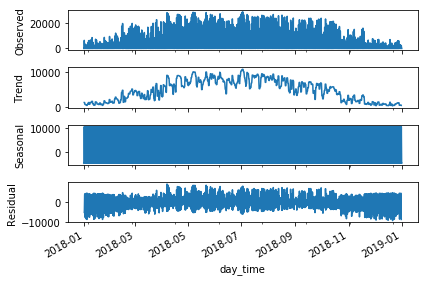

In [ ]:
tsd = data[data.year==2018][['day_time','DE_solar_generation_actual']].set_index('day_time')
tsd['DE_solar_generation_actual'] = tsd['DE_solar_generation_actual']
result = seasonal_decompose(tsd,freq=24)
result.plot()
plt.show()

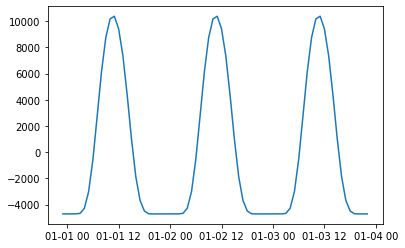

In [ ]:
plt.plot(result.seasonal.iloc[0:3*24])
plt.show()

## Weather

In [ ]:
weather.columns

Index(['utc_timestamp', 'DE_temperature', 'DE_radiation_direct_horizontal',
       'DE_radiation_diffuse_horizontal', 'DE_precipitation', 'DE_cloud_cover',
       'DE_snow_mass', 'DE_air_density', 'DE_snowfall', 'day_time'],
      dtype='object')

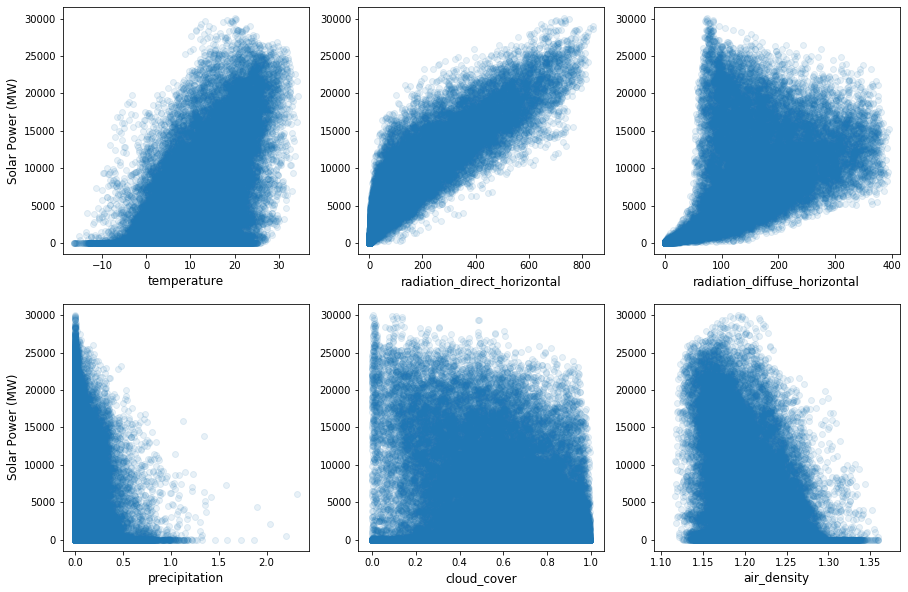

In [ ]:
cols= ['DE_temperature', 'DE_radiation_direct_horizontal','DE_radiation_diffuse_horizontal', 'DE_precipitation', 
       'DE_cloud_cover', 'DE_air_density']
fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(15,10))
for i,col in enumerate(cols):
    r = i//3
    c= i%3
    #print(r,c)
    axes[r][c].scatter(weather[col],data.DE_solar_generation_actual,alpha=0.1)
    axes[r][c].set_xlabel(col[3:],fontsize=12)
axes[0][0].set_ylabel("Solar Power (MW)",fontsize=12)    
axes[1][0].set_ylabel("Solar Power (MW)",fontsize=12)
plt.show()

In [ ]:
w_solar = weather[['DE_temperature', 'DE_radiation_direct_horizontal',
       'DE_radiation_diffuse_horizontal', 'DE_precipitation', 'DE_cloud_cover', 
                   'DE_air_density']].reset_index().drop(columns='index')

w_solar['solar_prod'] = data.reset_index().DE_solar_generation_actual.drop(columns='index')

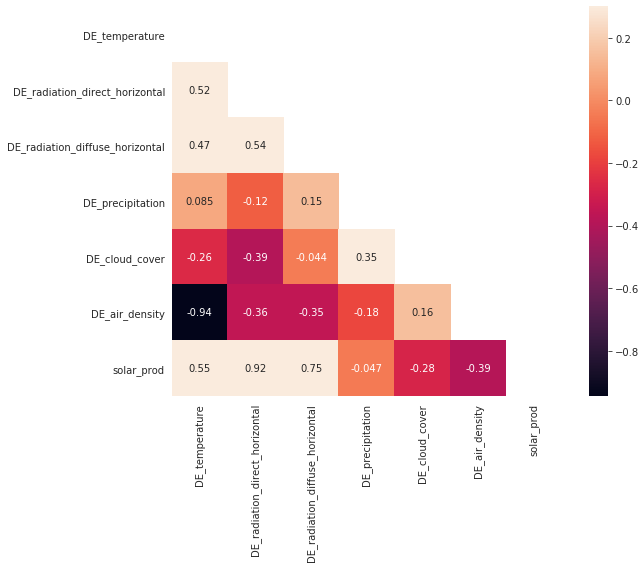

In [ ]:
#plt.figure(figsize=(10,8))
#sns.heatmap(w_solar.corr(),annot=True)
corr = w_solar.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True,annot=True)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.tight_layout()
plt.savefig('htmap.png')
plt.show() 

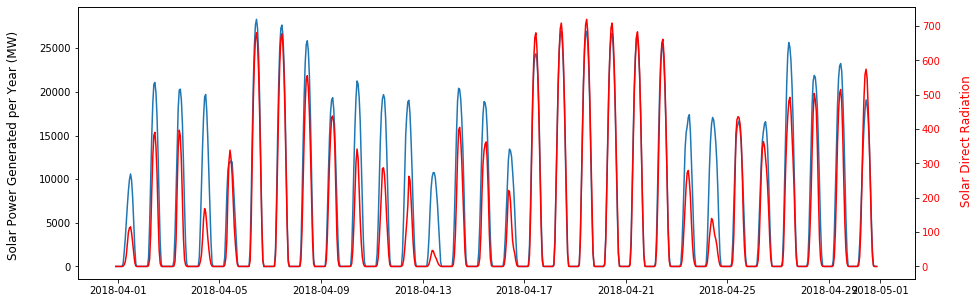

In [ ]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.plot(data[(data.year==2018) & (data.month==4)].set_index('day_time').DE_solar_generation_actual)
ax1.set_ylabel('Solar Power Generated per Year (MW) \n', fontsize=12)

ax2 = ax1.twinx()
weather['year']= weather['day_time'].apply(lambda s:s.year)
weather['month']= weather['day_time'].apply(lambda s:s.month)
ax2.plot(weather[(weather.year==2018) & (weather.month==4)].set_index('day_time').DE_radiation_direct_horizontal,'r-')
ax2.set_ylabel('\n Solar Direct Radiation',color='r',fontsize=12)

for t in ax2.get_yticklabels():
    t.set_color('r')
#ax1.set_xlabel("", fontsize=12)
plt.show()

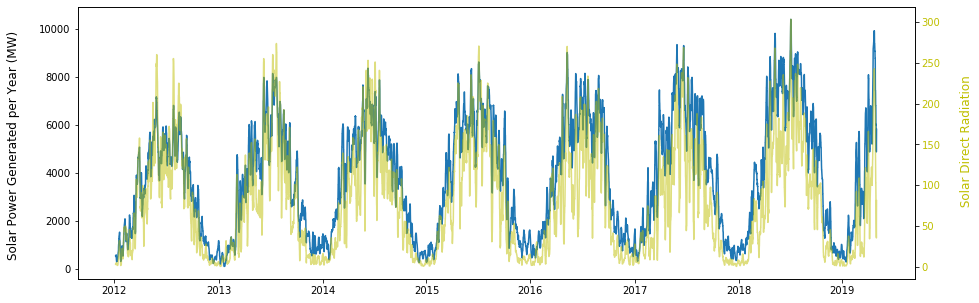

In [ ]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(111)
ax1.plot(data.set_index('day_time').DE_solar_generation_actual.rolling(window=24*4).mean())
ax1.set_ylabel('Solar Power Generated per Year (MW) \n', fontsize=12)

ax2 = ax1.twinx()
weather['year']= weather['day_time'].apply(lambda s:s.year)
weather['month']= weather['day_time'].apply(lambda s:s.month)
ax2.plot(weather.set_index('day_time').DE_radiation_direct_horizontal.rolling(window=24*4).mean(),'y-',alpha=0.5)
ax2.set_ylabel('\n Solar Direct Radiation',color='y',fontsize=12)

for t in ax2.get_yticklabels():
    t.set_color('y')
#ax1.set_xlabel("", fontsize=12)
plt.show()

Regarding the generation of solar power over the years from 2012 to 2019, we can notice two things - <br>
First, there is a seasonal pattern regarding how much the solar energy is generated during the period of one year. As we can see from this graph, the solar energy generated is lesser around the beginning and ending time of the year when compared to the middle months of each year. <br>
A second insight that we can see here is how there is a subtle increment in the amount of solar power generated in each succeeding year. Now, let us have a look at the monthly and hourly pattern of solar power generation


Thank you!